# Import learning data

In [164]:
import pandas as pd

training_data_path = "../learning_data/data/win_rate/preflop/50000-data-1000-simulation-2-players-win-rate-data.csv"
test_data_path = "../learning_data/data/win_rate/preflop/10000-data-1000-simulation-2-players-win-rate-data.csv"
train_df = pd.read_csv(training_data_path)
test_df = pd.read_csv(test_data_path)

# About learning data

In [165]:
print train_df.shape, test_df.shape

(50000, 5) (10000, 5)


In [166]:
train_df.head()

,hole1,hole2,win_rate,hole1_id,hole2_id
0,ST,S5,0.557,49,44
1,S6,H7,0.527,45,33
2,C6,C2,0.534,6,2
3,S6,D7,0.547,45,20
4,D5,S5,0.600,18,44


In [159]:
train_df.describe()

,win_rate,hole1_id,hole2_id
count,50000.000000,50000.000000,50000.000000
mean,0.585750,26.515840,26.430540
std,0.062115,15.014268,14.997453
min,0.421000,1.000000,1.000000
25%,0.544000,13.000000,13.000000
50%,0.583000,27.000000,26.000000
75%,0.623000,40.000000,40.000000
max,0.889000,52.000000,52.000000


In [160]:
test_df.describe()

,win_rate,hole1_id,hole2_id
count,10000.000000,10000.000000,10000.000000
mean,0.585766,26.518600,26.689300
std,0.063277,15.105796,14.934968
min,0.427000,1.000000,1.000000
25%,0.543000,13.000000,14.000000
50%,0.583000,27.000000,27.000000
75%,0.622000,40.000000,40.000000
max,0.881000,52.000000,52.000000


# Data Processing

## card id -> 1-hot vector

In [167]:
import numpy as np

gen_one_hot = lambda h1, h2: [1 if i in [h1, h2] else 0 for i in range(1,53)]
train_df["onehot"] = train_df.apply(lambda row: gen_one_hot(row['hole1_id'], row['hole2_id']), axis=1)
test_df["onehot"] = test_df.apply(lambda row: gen_one_hot(row['hole1_id'], row['hole2_id']), axis=1)

## Format data (pandas.df -> numpy.ndarray)

In [180]:
to_ndarray = lambda X: np.array([np.array(x) for x in X])
train_x, train_y = [to_ndarray(array) for array in [train_df["onehot"].values, train_df["win_rate"].values]]
test_x, test_y = [to_ndarray(array) for array in [test_df["onehot"].values, test_df["win_rate"].values]]
print "shape of training data => x: %s, y: %s" % (train_x.shape, train_y.shape)
print "shape of test data => x: %s, y: %s" % (val_x.shape, val_y.shape)

shape of training data => x: (40000, 52), y: (40000,)
shape of test data => x: (10000, 52), y: (10000,)


# Create model

In [171]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(60, input_dim=52))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss="mse",  optimizer="rmsprop")

# Train model

In [172]:
history = model.fit(train_x, train_y, batch_size=128, nb_epoch=1000, validation_split=0.1, verbose=0)

# Check model performance

## Visualize loss transition

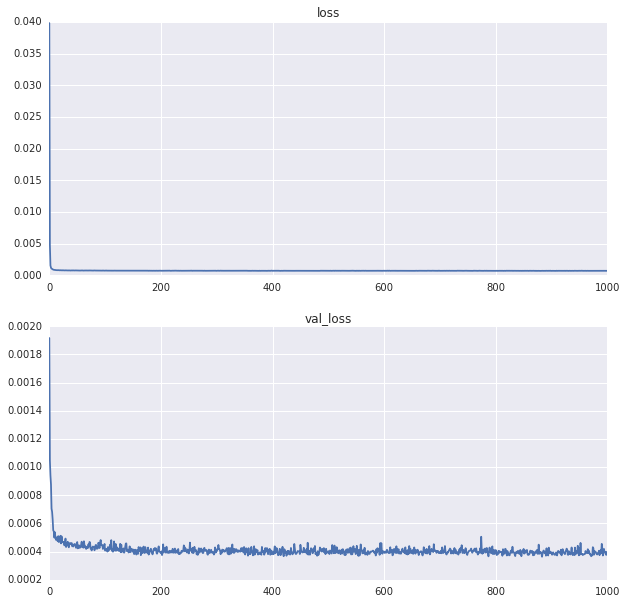

In [174]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for idx, key in enumerate(history.history, start=1):
    plt.subplot(2, 1, idx)
    plt.plot(range(len(history.history[key])), history.history[key])
    plt.title(key)
plt.show()

## Test model performance by MSE 

In [178]:
from sklearn.metrics import mean_squared_error

def print_model_performance(model, train_x, train_y, test_x, test_y):
    print 'MSE on training data = {score}'.format(score=mean_squared_error(model.predict(train_x), train_y))
    print 'MSE on test data = {score}'.format(score=mean_squared_error(model.predict(test_x), test_y))

In [179]:
print_model_performance(model, train_x, train_y, test_x, test_y)

MSE on training data = 0.000388531779299
MSE on test data = 0.000407883641716


## See model prediction on sample data

In [177]:
from pypokerengine.engine.card import Card

test_case = [
    (1, Card.SPADE, 1, Card.CLUB, 0.871), 
    (3, Card.HEART, 2, Card.SPADE, 0.477),
    (10, Card.CLUB, 13, Card.HEART, 0.676)
]
gen_one_hot = lambda h1, h2: [1 if i in [h1, h2] else 0 for i in range(1,53)]

df = pd.DataFrame()
for rank1, suit1, rank2, suit2, expected in test_case:
    hole1 = Card(rank=rank1, suit=suit1)
    hole2 = Card(rank=rank2, suit=suit2)
    hole = [hole1, hole2]
    x = gen_one_hot(*[card.to_id() for card in hole])
    X = np.array([x])
    y = model.predict(X)[0][0]
    print "HOLE = [%s, %s] => win_rate = { prediction=%f, expected=%f }" % tuple(map(str, hole)+ [y , expected])

HOLE = [SA, CA] => win_rate = { prediction=0.832442, expected=0.871000 }
HOLE = [H3, S2] => win_rate = { prediction=0.492687, expected=0.477000 }
HOLE = [CT, HK] => win_rate = { prediction=0.647034, expected=0.676000 }
